<a href="https://colab.research.google.com/github/LokiAndere/MIARFID-VPC-2019-20/blob/master/swap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions

from keras import backend
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
from imageio import imwrite

Using TensorFlow backend.


In [3]:
!rm *.tgz *.png 
!wget https://www.dropbox.com/s/pppk3ltnci0damv/style.tgz
!tar xvzf style.tgz

rm: cannot remove '*.tgz': No such file or directory
rm: cannot remove '*.png': No such file or directory
--2020-05-30 21:03:07--  https://www.dropbox.com/s/pppk3ltnci0damv/style.tgz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/pppk3ltnci0damv/style.tgz [following]
--2020-05-30 21:03:07--  https://www.dropbox.com/s/raw/pppk3ltnci0damv/style.tgz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc16b4ca29ce9efce08e5967d193.dl.dropboxusercontent.com/cd/0/inline/A4sNiZiPnsh7RIG7LJdj9GERTJqxZI4WkwJQkaCnumq3Xm5H61TP36ed-dUbr1D7I9RqLcqu383VmvJWGeLRBIFE80kRiffEomJ16OmG4IfzEQ/file# [following]
--2020-05-30 21:03:08--  https://uc16b4ca29ce9efce08e5967d193.dl.dropboxusercontent.com/cd/0/inline/A4sNiZiPnsh7RIG7LJdj9GERTJqxZI4WkwJ

(1, 512, 512, 3)
(1, 512, 512, 3)


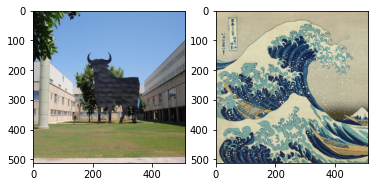

In [12]:
content_image=Image.open('upv.png')
content_image=content_image.resize((512,512))

style_image= Image.open('style.png')
style_image=style_image.resize((512,512))

content_array=np.asarray(content_image,dtype='float32')
content_array=np.expand_dims(content_array,axis=0)

style_array=np.asarray(style_image,dtype='float32')
style_array=np.expand_dims(style_array,axis=0)

print(content_array.shape)
print(style_array.shape)

plt.subplot(1, 2, 1)
plt.imshow(content_image, url='Content Image')

plt.subplot(1, 2, 2)
plt.imshow(style_image, url='Style Image')
plt.show()

In [0]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
#to match VGG16
style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68

In [0]:
content_array = content_array[:, :, :, ::-1]
style_array = style_array[:, :, :, ::-1]

In [0]:
height=512
width=512
content_image=backend.variable(content_array)
style_image=backend.variable(style_array)
combination_image=backend.placeholder((1,height,width,3))

input_tensor=backend.concatenate([content_image,style_image,combination_image],axis=0)

model=VGG19(input_tensor=input_tensor,weights='imagenet', include_top=False)
model.summary()

content_weight = 0.02
style_weight = 50.0
total_variation_weight = 1.0

layers=dict([(layer.name, layer.output) for layer in model.layers])
print(layers)

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [23]:
height=512
width=512
content_image=backend.variable(content_array)
style_image=backend.variable(style_array)
combination_image=backend.placeholder((1,height,width,3))

input_tensor=backend.concatenate([content_image,style_image,combination_image],axis=0)

model=VGG16(input_tensor=input_tensor,weights='imagenet', include_top=False)
model.summary()

content_weight = 0.025
style_weight = 20.0
total_variation_weight = 1.0

layers=dict([(layer.name, layer.output) for layer in model.layers])
print(layers)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [24]:
loss=backend.variable(0.)

def content_loss(content, combination):
    return 0.5*backend.sum(backend.square(content-combination))

layer_features=layers['block2_conv2']
print(layer_features.shape)
content_image_features=layer_features[0,:,:,:]
combination_features=layer_features[2,:,:,:]
loss=loss+content_weight*content_loss(content_image_features,combination_features)

def gram_matrix(x):
    features=backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    gram=backend.dot(features, backend.transpose(features))
    return gram

def style_loss(style,combination):
    S=gram_matrix(style)
    C=gram_matrix(combination)
    channels=3
    size=height * width
    st=backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
    return st

(3, 256, 256, 128)


In [0]:
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

for layer_name in feature_layers:
    layer_features=layers[layer_name]
    style_features=layer_features[1,:,:,:]
    combination_features=layer_features[2,:,:,:]
    sl=style_loss(style_features,combination_features)
    loss+=(style_weight/len(feature_layers))*sl

def total_variation_loss(x):
    a=backend.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))
loss += total_variation_weight * total_variation_loss(combination_image)

In [0]:
grads = backend.gradients(loss, combination_image)

outputs=[loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):
    def __init__(self):
        self.loss_value=None
        self.grads_values=None
    
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

Start of iteration 0
53104550000.0
Iteration 0 completed in 4s
Start of iteration 1
28383670000.0
Iteration 1 completed in 4s
Start of iteration 2
19086471000.0
Iteration 2 completed in 4s
Start of iteration 3
17107302000.0
Iteration 3 completed in 4s
Start of iteration 4
16692246000.0
Iteration 4 completed in 4s
Start of iteration 5
16508425000.0
Iteration 5 completed in 4s
Start of iteration 6
16408074000.0
Iteration 6 completed in 4s
Start of iteration 7
16348312000.0
Iteration 7 completed in 4s
Start of iteration 8
16307850000.0
Iteration 8 completed in 4s
Start of iteration 9
16278446000.0
Iteration 9 completed in 4s
Start of iteration 10
16257318000.0
Iteration 10 completed in 4s
Start of iteration 11
16241940000.0
Iteration 11 completed in 4s
Start of iteration 12
16229720000.0
Iteration 12 completed in 4s
Start of iteration 13
16219909000.0
Iteration 13 completed in 4s
Start of iteration 14
16212107000.0
Iteration 14 completed in 4s
Start of iteration 15
16205599000.0
Iteration

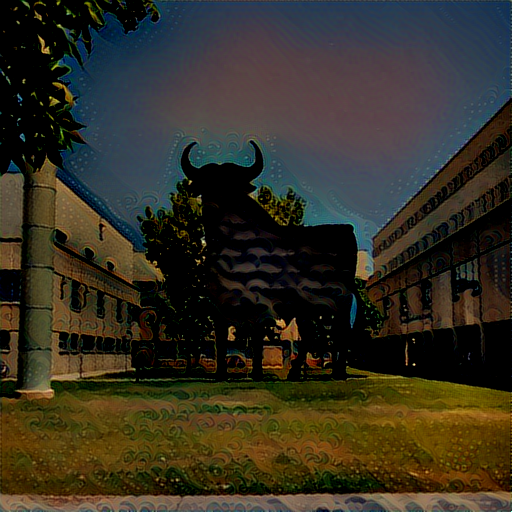

In [27]:
evaluator=Evaluator()

x=np.random.uniform(0,255,(1,height,width,3))-128.0

iterations = 20

import time
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                           fprime=evaluator.grads, maxfun=20)
    print(min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

print
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)

Start of iteration 0
23735240000.0
Iteration 0 completed in 11s
Start of iteration 1
14657969000.0
Iteration 1 completed in 4s
Start of iteration 2
12138358000.0
Iteration 2 completed in 4s
Start of iteration 3
11577623000.0
Iteration 3 completed in 4s
Start of iteration 4
11375754000.0
Iteration 4 completed in 4s
Start of iteration 5
11249412000.0
Iteration 5 completed in 4s
Start of iteration 6
11163218000.0
Iteration 6 completed in 4s
Start of iteration 7
11100692000.0
Iteration 7 completed in 4s
Start of iteration 8
11052330000.0
Iteration 8 completed in 4s
Start of iteration 9
11016280000.0
Iteration 9 completed in 4s
Start of iteration 10
10987794000.0
Iteration 10 completed in 4s
Start of iteration 11
10966099000.0
Iteration 11 completed in 4s
Start of iteration 12
10948128000.0
Iteration 12 completed in 4s
Start of iteration 13
10933623000.0
Iteration 13 completed in 4s
Start of iteration 14
10922612000.0
Iteration 14 completed in 4s
Start of iteration 15
10913863000.0
Iteratio

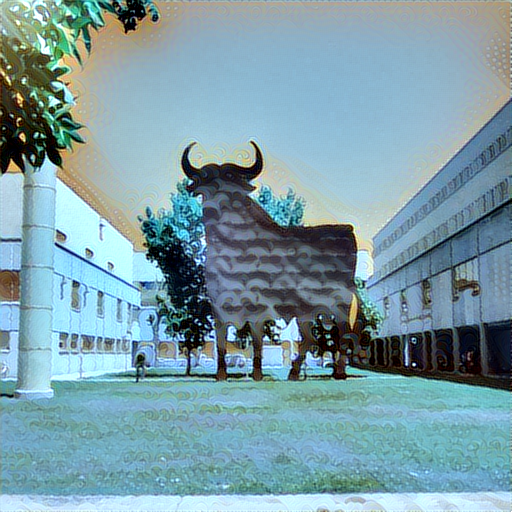

In [20]:
evaluator=Evaluator()

x=np.random.uniform(0,255,(1,height,width,3))-128.0

iterations = 20

import time
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                           fprime=evaluator.grads, maxfun=20)
    print(min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

print
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)

Start of iteration 0
12660010000000.0
Iteration 0 completed in 12s
Start of iteration 1
1764385000000.0
Iteration 1 completed in 7s
Start of iteration 2
184455360000.0
Iteration 2 completed in 7s
Start of iteration 3
104278065000.0
Iteration 3 completed in 7s
Start of iteration 4
75296915000.0
Iteration 4 completed in 7s
Start of iteration 5
62984397000.0
Iteration 5 completed in 7s
Start of iteration 6
53827793000.0
Iteration 6 completed in 7s
Start of iteration 7
47325550000.0
Iteration 7 completed in 7s
Start of iteration 8
42849624000.0
Iteration 8 completed in 7s
Start of iteration 9
39940694000.0
Iteration 9 completed in 7s
Start of iteration 10
37017390000.0
Iteration 10 completed in 7s
Start of iteration 11
35432145000.0
Iteration 11 completed in 7s
Start of iteration 12
34144737000.0
Iteration 12 completed in 7s
Start of iteration 13
33181092000.0
Iteration 13 completed in 7s
Start of iteration 14
32200743000.0
Iteration 14 completed in 7s
Start of iteration 15
31175840000.0
I

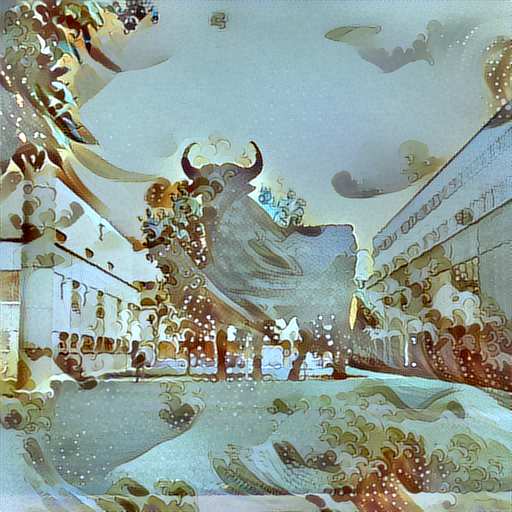

In [0]:
evaluator=Evaluator()

x=np.random.uniform(0,255,(1,height,width,3))-128.0

iterations = 135

import time
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                           fprime=evaluator.grads, maxfun=20)
    print(min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

print
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)

Start of iteration 0
5440642500000.0
Iteration 0 completed in 6s
Start of iteration 1
368092250000.0
Iteration 1 completed in 6s
Start of iteration 2
135072270000.0
Iteration 2 completed in 6s
Start of iteration 3
89667576000.0
Iteration 3 completed in 6s
Start of iteration 4
72936470000.0
Iteration 4 completed in 6s
Start of iteration 5
63029146000.0
Iteration 5 completed in 6s
Start of iteration 6
57659650000.0
Iteration 6 completed in 6s
Start of iteration 7
53522980000.0
Iteration 7 completed in 6s
Start of iteration 8
50723332000.0
Iteration 8 completed in 6s
Start of iteration 9
48631108000.0
Iteration 9 completed in 6s
Start of iteration 10
46678323000.0
Iteration 10 completed in 6s
Start of iteration 11
45274284000.0
Iteration 11 completed in 6s
Start of iteration 12
44155820000.0
Iteration 12 completed in 6s
Start of iteration 13
43033820000.0
Iteration 13 completed in 6s
Start of iteration 14
42103054000.0
Iteration 14 completed in 6s
Start of iteration 15
41183867000.0
Itera

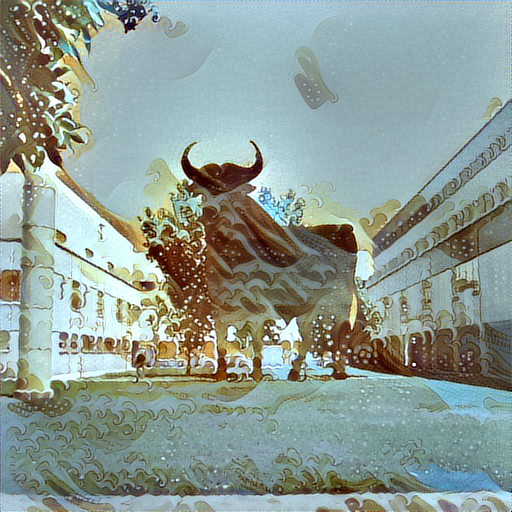

In [0]:
evaluator=Evaluator()

x=np.random.uniform(0,255,(1,height,width,3))-128.0

iterations = 135

import time
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                           fprime=evaluator.grads, maxfun=20)
    print(min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

print
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
#x[:, :, 0] += 103.939
#x[:, :, 1] += 116.779
#x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)